## BTC Option Volatility Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (16, 10)

### Generate underlying index price time series

At the moment we do not record the index prices so it must be obtained from option data by naively assuming that the largest data file contains the most index price data. Fix this in future.

In [3]:
csv_path = '/home/fp361/cloud-mounts/deribit_orderbook_data/'

In [4]:
import os

In [5]:
csv_list = os.listdir(csv_path)

pairs = []
for file in csv_list:

    location = os.path.join(csv_path, file)

    size = os.path.getsize(location)
    pairs.append((size, file))

pairs.sort(key=lambda s: s[0])

pairs.reverse()
largest = pairs[0]
print(largest)

(7605186, 'BTC-26JUN20-9000-C.csv')


In [6]:
index_prices = pd.read_csv(os.path.join(csv_path, largest[1])).filter(['timestamp', 'index_price'])
index_prices['timestamp'] = pd.to_datetime(index_prices['timestamp'], unit='ms')
index_prices = index_prices.set_index('timestamp')
index_prices

,index_price
timestamp,
2020-03-29 17:47:00.926,6107.48
2020-03-29 17:49:13.858,6106.78
2020-03-29 17:50:52.549,6106.66
2020-03-29 17:52:27.221,6107.50
2020-03-29 17:56:12.810,6118.13
...,...
2020-04-28 14:57:08.504,7715.13
2020-04-28 15:00:51.087,7681.86
2020-04-28 15:04:42.525,7701.54


In [7]:
index_prices_5min = pd.DataFrame()
index_prices_5min['index_price'] = index_prices.index_price.resample('5min').last()
index_prices_5min

,index_price
timestamp,
2020-03-29 17:45:00,6106.78
2020-03-29 17:50:00,6107.50
2020-03-29 17:55:00,6118.13
2020-03-29 18:00:00,6099.96
2020-03-29 18:05:00,6101.16
...,...
2020-04-28 14:50:00,7740.52
2020-04-28 14:55:00,7715.13
2020-04-28 15:00:00,7701.54


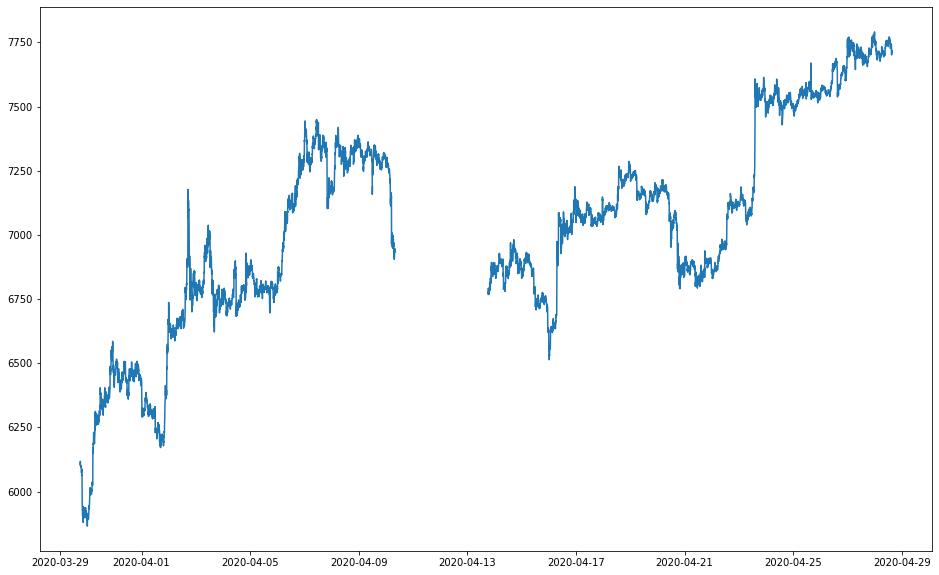

In [8]:
plt.plot(index_prices_5min)

### Function to load required orderbook data

In [9]:
import glob

# Shorthand for dictionary lookup
co = 'C' # Call option
po = 'P' # Put option

In [258]:
def read_orderbook_data(csv_paths, expiry, data_dict=dict()):
    if expiry not in data_dict:
        data_dict[expiry] = dict()
    else:
        # Already read
        return data_dict
    
    near_next_csv = list()
    for path in csv_paths:
        near_next_csv += glob.glob(path + f'BTC-{expiry}-*-*.csv')

    #if len(near_next_csv) == 0:
    #    raise ValueError(f'{expiry} data unavailable!')
        
    print(f'Reading {expiry} data from disk...')
    for file_path in near_next_csv:
        instrument = os.path.basename(file_path).split('-')
        exp, strike, cp = instrument[1], int(instrument[2]), instrument[3].split('.')[0]  

        if strike not in data_dict[exp]:
            data_dict[exp][strike] = dict()
        try:    
            df = pd.read_csv(file_path).filter(['timestamp', 'best_bid_price', 'best_ask_price'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
            df = df.set_index('timestamp')
            df_resampled = df.resample('5min').last().dropna()
        except Exception as e:
            print('ERROR', file_path, e)
            
        data_dict[exp][strike][cp] = df_resampled
        
    return data_dict        

Test:

In [259]:
# This call should return a five-minute resampled time-series dataframe of best bids and asks for BTC-3APR20-6750-C.
test = read_orderbook_data([csv_path], '3APR20')['3APR20'][6750][co]
test

Reading 3APR20 data from disk...


,best_bid_price,best_ask_price
timestamp,,
2020-03-29 17:45:00,0.0090,0.0110
2020-03-29 17:50:00,0.0090,0.0110
2020-03-29 17:55:00,0.0090,0.0110
2020-03-29 18:00:00,0.0090,0.0110
2020-03-29 18:05:00,0.0090,0.0110
...,...,...
2020-04-03 07:40:00,0.0190,0.0310
2020-04-03 07:45:00,0.0220,0.0300
2020-04-03 07:50:00,0.0220,0.0300


## Volatility Indices

### Preparing data for vxbt_calc

For testing, choose random time.

In [12]:
now = pd.to_datetime('2020-01-24 00:00:00')

Import our *vxbt_calc* module.

In [33]:
from vxbt_calc import vxbt_calc

<module 'vxbt_calc.vxbt_calc' from '/home/fp361/bitfear/vix-implementation/vxbt_calc/vxbt_calc.py'>

In [18]:
near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)
csv_path2 = '/home/fp361/bitfear/deribit-orderbook-scraper/scraped_data/'

orderbook_data = dict()
orderbook_data = read_orderbook_data([csv_path, csv_path2], near_expiry, orderbook_data)
orderbook_data = read_orderbook_data([csv_path, csv_path2], next_expiry, orderbook_data)

Reading 24JAN20 data from disk...
Reading 31JAN20 data from disk...


In [19]:
print(near_expiry, next_expiry)
print(orderbook_data.keys())

24JAN20 31JAN20
dict_keys(['24JAN20', '31JAN20'])


The xvbt_calc module requires four dataframes - near_calls_df, near_puts_df, next_calls_df, next_puts_df - to perform an offline index calculation.

In [20]:
def build_dataframes(time, near_expiry, next_expiry, data_dict):
    near_calls = dict()
    near_puts = dict()
    next_calls = dict()
    next_puts = dict()
    
    for strike in data_dict[near_expiry]:
        near_calls[strike] = data_dict[near_expiry][strike]['C'].loc[time].astype(float)
        near_puts[strike] = data_dict[near_expiry][strike]['P'].loc[time].astype(float)        
    
    for strike in data_dict[next_expiry]:
        next_calls[strike] = data_dict[next_expiry][strike]['C'].loc[time].astype(float)
        next_puts[strike] = data_dict[next_expiry][strike]['P'].loc[time].astype(float)
        
    near_calls_df = pd.DataFrame.from_dict(near_calls, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    near_puts_df = pd.DataFrame.from_dict(near_puts, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    next_calls_df = pd.DataFrame.from_dict(next_calls, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    next_puts_df = pd.DataFrame.from_dict(next_puts, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    
    return near_calls_df, near_puts_df, next_calls_df, next_puts_df

In [21]:
dfs = build_dataframes(now, near_expiry, next_expiry, orderbook_data)
dfs[0]

,best_bid,best_ask
6250,0.2455,0.2645
6500,0.2155,0.2335
6750,0.1855,0.2045
7000,0.1550,0.1750
7250,0.1250,0.1455
7500,0.0935,0.1150
7750,0.0670,0.0845
8000,0.0385,0.0545
8250,0.0155,0.0175
8500,0.0015,0.0020


In [34]:
vxbt_calc.get_indices(live=False, time=now, dfs=dfs)

(0.8321195582506019, 0.8023252322774532, 0.0001035257407708813)

### Computing the time series

In [35]:
import datetime

In [36]:
orderbook_data = dict()

now = pd.to_datetime('2020-04-17 00:00:00')
end = datetime.datetime.now()

indices_df = pd.DataFrame(columns=['timestamp', 'vxbt', 'gvxbt', 'avxbt'])

while now < end:
    near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)
    
    orderbook_data = read_orderbook_data([csv_path, csv_path2], near_expiry, orderbook_data)
    orderbook_data = read_orderbook_data([csv_path, csv_path2], next_expiry, orderbook_data)
    
    if not orderbook_data[near_expiry] or not orderbook_data[next_expiry]:
        print(f'WARNING: Insufficient data at {now}')
        now += datetime.timedelta(minutes=5)
        continue

    try:
        dfs = build_dataframes(now, near_expiry, next_expiry, orderbook_data)
        VXBT, GVXBT, AVXBT = vxbt_calc.get_indices(live=False, time=now, dfs=dfs)
        
        indices_df = indices_df.append({'timestamp': now, 'vxbt': VXBT, 'gvxbt': GVXBT, 'avxbt': AVXBT}, ignore_index=True)
    #except KeyError:
    #    print(f'WARNING: Insufficient data at {now}')
    except Exception as e:
        print(f'WARNING: Unhandled error at {now}')
        print(e)
    
    now += datetime.timedelta(minutes=5)


Reading 17APR20 data from disk...
Reading 24APR20 data from disk...
Timestamp('2020-04-17 00:00:00')
Timestamp('2020-04-17 00:05:00')
Timestamp('2020-04-17 00:10:00')
Timestamp('2020-04-17 00:15:00')
Timestamp('2020-04-17 00:20:00')
Timestamp('2020-04-17 00:25:00')
Timestamp('2020-04-17 00:30:00')
Timestamp('2020-04-17 00:35:00')
Timestamp('2020-04-17 00:40:00')
Timestamp('2020-04-17 00:45:00')
Timestamp('2020-04-17 00:50:00')
Timestamp('2020-04-17 00:55:00')
Timestamp('2020-04-17 01:00:00')
Timestamp('2020-04-17 01:05:00')
Timestamp('2020-04-17 01:10:00')
Timestamp('2020-04-17 01:15:00')
Timestamp('2020-04-17 01:20:00')
Timestamp('2020-04-17 01:25:00')
Timestamp('2020-04-17 01:30:00')
Timestamp('2020-04-17 01:35:00')
Timestamp('2020-04-17 01:40:00')
Timestamp('2020-04-17 01:45:00')
Timestamp('2020-04-17 01:50:00')
Timestamp('2020-04-17 01:55:00')
Timestamp('2020-04-17 02:00:00')
Timestamp('2020-04-17 02:05:00')
Timestamp('2020-04-17 02:10:00')
Timestamp('2020-04-17 02:15:00')
Timestam

Timestamp('2020-04-20 17:25:00')
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class '

In [37]:
indices_df = indices_df.set_index('timestamp')
indices_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-17 08:35:00,1.043923,0.796232,0.000114
2020-04-17 08:40:00,1.043290,0.796363,0.000114
2020-04-17 08:45:00,1.044881,0.791626,0.000113
2020-04-17 08:50:00,1.041748,0.799744,0.000114
2020-04-17 08:55:00,1.034267,0.803266,0.000115
...,...,...,...
2020-04-28 17:20:00,0.827456,0.803011,0.000104
2020-04-28 17:25:00,0.830045,0.801964,0.000103
2020-04-28 17:30:00,0.829416,0.799638,0.000103


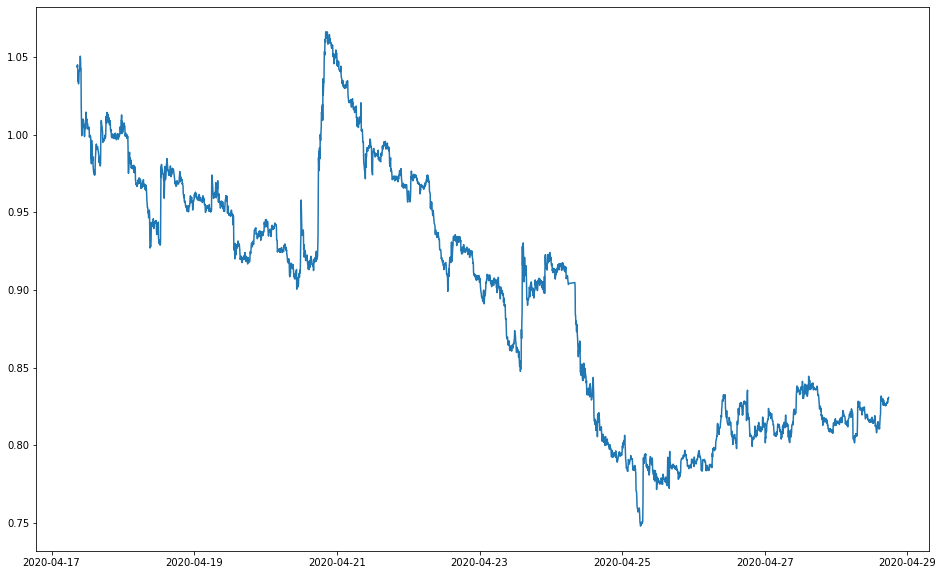

In [38]:
plt.plot(indices_df['vxbt'])

Text(0.5, 0.98, 'Volatility Time Series (2020-04-17 00:00:00-)')

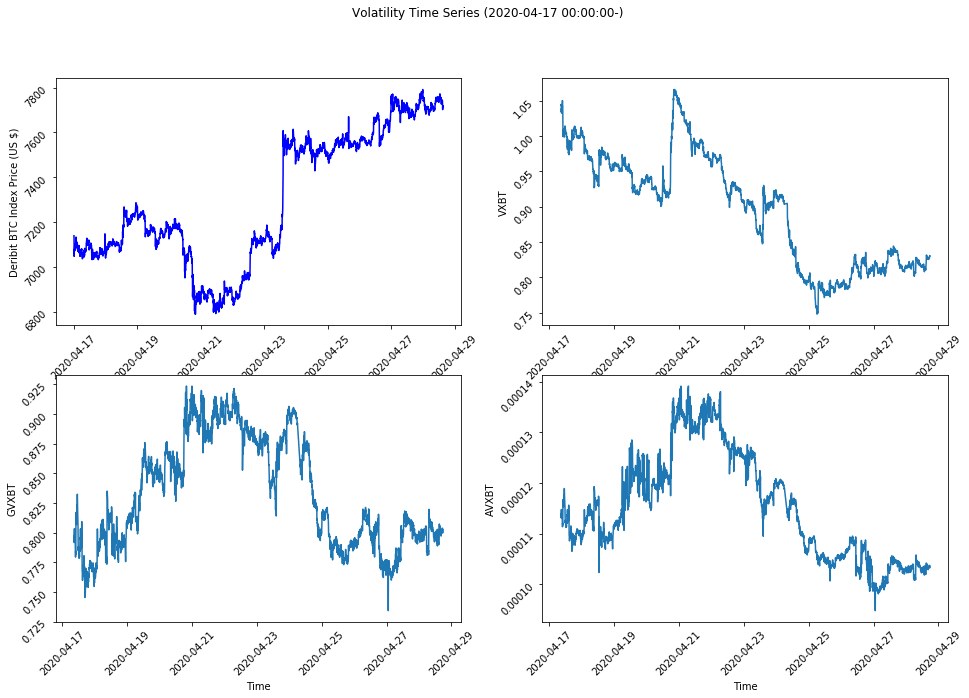

In [39]:
fig, ax =  plt.subplots(2,2)

plot_start = '2020-04-17 00:00:00'

ax[0][0].plot(index_prices_5min[plot_start:], color='blue')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Deribit BTC Index Price (US $)')
ax[0][0].tick_params(labelrotation=45)

ax[0][1].plot(indices_df['vxbt'][plot_start:])
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('VXBT')
ax[0][1].tick_params(labelrotation=45)

ax[1][0].plot(indices_df['gvxbt'][plot_start:])
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('GVXBT')
ax[1][0].tick_params(labelrotation=45)

ax[1][1].plot(indices_df['avxbt'][plot_start:])
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('AVXBT')
ax[1][1].tick_params(labelrotation=45)

fig.suptitle(f'Volatility Time Series ({plot_start}-)')

### Volatility index time series from live calculator

In [276]:
live_df = pd.read_csv('live_indices.csv').drop(['index_usd'], axis=1)
live_df['timestamp'] = pd.to_datetime(live_df['timestamp'])
live_df = live_df.set_index('timestamp')
live_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-19 20:05:00,0.224655,4.558362,0.000651
2020-04-19 20:06:00,0.223939,4.555675,0.000651
2020-04-19 20:07:00,0.225939,4.523634,0.000646
2020-04-19 20:08:00,0.225909,4.527518,0.000647
2020-04-19 20:09:00,0.225865,4.525514,0.000647
...,...,...,...
2020-05-11 16:54:00,1.313524,1.172047,0.000138
2020-05-11 16:55:00,1.313623,1.172203,0.000138
2020-05-11 16:56:00,1.316412,1.171340,0.000138


In [277]:
both_df = pd.concat([indices_df, live_df.loc['2020-04-28 17:42:00':]])
both_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-17 08:35:00,1.043923,0.796232,0.000114
2020-04-17 08:40:00,1.043290,0.796363,0.000114
2020-04-17 08:45:00,1.044881,0.791626,0.000113
2020-04-17 08:50:00,1.041748,0.799744,0.000114
2020-04-17 08:55:00,1.034267,0.803266,0.000115
...,...,...,...
2020-05-11 16:54:00,1.313524,1.172047,0.000138
2020-05-11 16:55:00,1.313623,1.172203,0.000138
2020-05-11 16:56:00,1.316412,1.171340,0.000138


Text(0.5, 0.98, 'Volatility Time Series (2020-04-17 00:00:00-)')

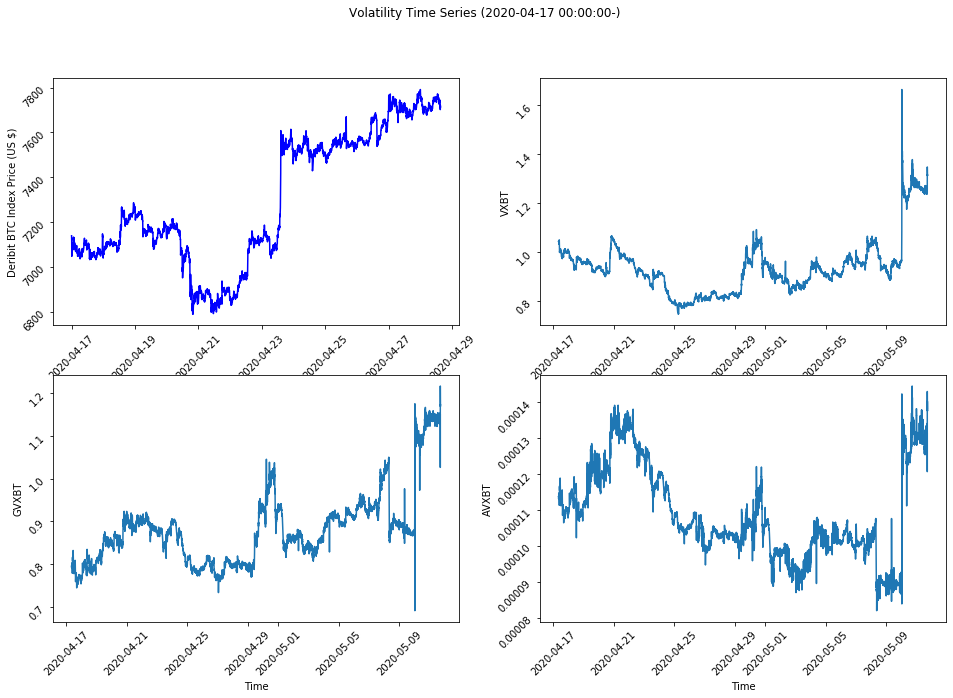

In [278]:
fig, ax =  plt.subplots(2,2)

#plot_start = live_df.index[0]

ax[0][0].plot(index_prices_5min[plot_start:], color='blue')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Deribit BTC Index Price (US $)')
ax[0][0].tick_params(labelrotation=45)

ax[0][1].plot(both_df['vxbt'][plot_start:])
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('VXBT')
ax[0][1].tick_params(labelrotation=45)

ax[1][0].plot(both_df['gvxbt'][plot_start:])
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('GVXBT')
ax[1][0].tick_params(labelrotation=45)

ax[1][1].plot(both_df['avxbt'][plot_start:])
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('AVXBT')
ax[1][1].tick_params(labelrotation=45)

fig.suptitle(f'Volatility Time Series ({plot_start}-)')

### Export for use in ARIMA/regression models

In [279]:
both_df[plot_start:].to_csv('volatility_data.csv')

***

## CoinAPI

In [82]:
import requests
import json

In [249]:
url_syms = 'https://rest.coinapi.io/v1/symbols?filter_symbol_id=DERIBIT_OPT_BTC_USD_{}'
url_quotes = 'https://rest.coinapi.io/v1/quotes/{}/history?time_start={}&time_end={}&limit=100000'

#headers = {'X-CoinAPI-Key' : 'B0F2DAAE-D649-4C30-AB64-F7943DC7ED81'}
headers = {'X-CoinAPI-Key' : '6E38A06D-403C-4B71-9011-8CCAB6EC2C19'}

capi_data_path = '/home/fp361/bitfear/vix-implementation/coinapi/'

In [269]:
instrument_start_end = dict()

start_c = pd.to_datetime('2019-05-01 00:00:00')
end_c = pd.to_datetime('2020-05-01 00:00:00')

now_c = start_c

while now_c <= end_c:
    for expiry in vxbt_calc.get_near_next_terms(now_c)[:1]:
        if expiry in instrument_start_end:
            instrument_start_end[expiry]['end'] = now_c + datetime.timedelta(minutes=15)
        else:
            instrument_start_end[expiry] = {'start': now_c - datetime.timedelta(hours=1, minutes=15), 'end': ''}
            
    now_c += datetime.timedelta(hours=1)

In [270]:
instrument_start_end

{'3MAY19': {'start': Timestamp('2019-04-30 22:45:00'),
  'end': Timestamp('2019-05-03 08:15:00')},
 '10MAY19': {'start': Timestamp('2019-05-03 07:45:00'),
  'end': Timestamp('2019-05-10 08:15:00')},
 '17MAY19': {'start': Timestamp('2019-05-10 07:45:00'),
  'end': Timestamp('2019-05-17 08:15:00')},
 '24MAY19': {'start': Timestamp('2019-05-17 07:45:00'),
  'end': Timestamp('2019-05-24 08:15:00')},
 '31MAY19': {'start': Timestamp('2019-05-24 07:45:00'),
  'end': Timestamp('2019-05-31 08:15:00')},
 '7JUN19': {'start': Timestamp('2019-05-31 07:45:00'),
  'end': Timestamp('2019-06-07 08:15:00')},
 '14JUN19': {'start': Timestamp('2019-06-07 07:45:00'),
  'end': Timestamp('2019-06-14 08:15:00')},
 '21JUN19': {'start': Timestamp('2019-06-14 07:45:00'),
  'end': Timestamp('2019-06-21 08:15:00')},
 '28JUN19': {'start': Timestamp('2019-06-21 07:45:00'),
  'end': Timestamp('2019-06-28 08:15:00')},
 '5JUL19': {'start': Timestamp('2019-06-28 07:45:00'),
  'end': Timestamp('2019-07-05 08:15:00')},
 '1

In [246]:
def handle_coinapi(url, request_headers):
    response = requests.get(url, headers=request_headers)
    headers = response.headers
    content = json.loads(response.content.decode())

    try:
        limit_reached = int(headers['x-ratelimit-remaining']) - int(headers['x-ratelimit-request-cost']) < 5
    except KeyError:
        print(f'Response headers {headers}')
        print(f'Response content {content}')
        raise
    
    return content, limit_reached

In [247]:
limit_reached = False

In [274]:
completed_instruments = [file_path.split('/')[-1] for file_path in glob.glob(capi_data_path + '*.csv')]
completed_instruments

['BTC-17MAY19-9500-P.csv',
 'BTC-24MAY19-5500-P.csv',
 'BTC-24MAY19-6250-C.csv',
 'BTC-17MAY19-6000-P.csv',
 'BTC-17MAY19-6500-P.csv',
 'BTC-17MAY19-5250-C.csv',
 'BTC-3MAY19-4875-P.csv',
 'BTC-24MAY19-5000-P.csv',
 'BTC-17MAY19-5000-C.csv',
 'BTC-3MAY19-4500-C.csv',
 'BTC-10MAY19-6500-P.csv',
 'BTC-10MAY19-6000-P.csv',
 'BTC-10MAY19-5000-C.csv',
 'BTC-17MAY19-4750-C.csv',
 'BTC-17MAY19-8250-C.csv',
 'BTC-3MAY19-6000-P.csv',
 'BTC-17MAY19-7750-C.csv',
 'BTC-3MAY19-4500-P.csv',
 'BTC-24MAY19-6250-P.csv',
 'BTC-3MAY19-5500-C.csv',
 'BTC-24MAY19-5750-C.csv',
 'BTC-17MAY19-9500-C.csv',
 'BTC-17MAY19-6250-P.csv',
 'BTC-3MAY19-6000-C.csv',
 'BTC-17MAY19-6250-C.csv',
 'BTC-3MAY19-5500-P.csv',
 'BTC-24MAY19-6000-P.csv',
 'BTC-24MAY19-6500-C.csv',
 'BTC-10MAY19-4250-C.csv',
 'BTC-10MAY19-5500-C.csv',
 'BTC-17MAY19-9250-P.csv',
 'BTC-10MAY19-6500-C.csv',
 'BTC-10MAY19-5250-C.csv',
 'BTC-17MAY19-5500-P.csv',
 'BTC-3MAY19-5000-C.csv',
 'BTC-3MAY19-5625-P.csv',
 'BTC-10MAY19-5500-P.csv',
 'BTC-24MA

In [275]:
limit_reached = False

for expiry in instrument_start_end:
    if not limit_reached:
        start_time_string = instrument_start_end[expiry]['start'].isoformat() + 'Z'
        end_time_string = instrument_start_end[expiry]['end'].isoformat() + 'Z'
        expiry_string = datetime.datetime.strftime(instrument_start_end[expiry]['end'], '%y%m%d')
        
        url = url_syms.format(expiry_string)
        content, limit_reached = handle_coinapi(url, headers)

        instruments = [instrument['symbol_id'] for instrument in content]
        
        if limit_reached:
            print(f'CoinAPI limit reached after getting {expiry} instruments list.')
            break

        for instrument in content:
            name = instrument['symbol_id']
            strike, cp = name.split('_')[5:]
            fname = f'BTC-{expiry}-{strike}-{cp}.csv'
            
            if fname not in completed_instruments:
                url = url_quotes.format(name, start_time_string, end_time_string)
                content, limit_reached = handle_coinapi(url, headers)
                
                if limit_reached:
                    break

                df = pd.DataFrame.from_dict(content).drop(['symbol_id', 'time_coinapi', 'ask_size', 'bid_size'], axis=1).rename({'time_exchange': 'timestamp', 'ask_price':  'best_ask_price', 'bid_price': 'best_bid_price'}, axis=1).replace(-1, 0)
                df['timestamp'] = pd.to_datetime(df['timestamp']).values.astype(np.int64) // 10 ** 6
                df.to_csv(f'{capi_data_path}{fname}', index=False)

                last = name
                print(f'Successfully created {fname}.')
            
            else:
                print(f'Skipping {name} as {fname} already exists.')
                
    else:
        print(f'Limit reached after getting {last}.')
        break

Response headers {'date': 'Mon, 11 May 2020 16:48:54 GMT', 'content-type': 'application/json', 'transfer-encoding': 'chunked', 'request-context': 'appId=cid-v1:9006a036-a027-444b-9b12-21861d70ec00', 'x-ratelimit-limit': '1000', 'x-ratelimit-remaining': '-1809', 'x-ratelimit-reset': '2020-05-12T16:48:55.3819895Z'}
Response content {'error': 'Too many requests - You have exceeded your API key last 24 hour requests executed limit, please wait for new requests or contact support for upgrading your existing plan.', 'faq_0': 'Q: How requests are calculated? A: The request is a single API call to our REST API without `limit` parameter. Or with `limit` parameter, the request is counted every 100 data points returned by the API.', 'faq_1': 'Q: How I can monitor number of requests left? A: Every authenticated API call providing information about the current state of the limits in the HTTP response headers, more info here: https://docs.coinapi.io/#request-limits', 'faq_2': "Q: I'm on Professional

KeyError: 'x-ratelimit-request-cost'

In [261]:
test_c = read_orderbook_data([capi_data_path], '3MAY19')['3MAY19'][5000][co]
test_c

,best_bid_price,best_ask_price
timestamp,,
2019-04-30 23:00:00,0.0530,0.0570
2019-04-30 23:05:00,0.0515,0.0555
2019-04-30 23:10:00,0.0520,0.0555
2019-04-30 23:15:00,0.0515,0.0560
2019-04-30 23:20:00,0.0515,0.0550
...,...,...
2019-05-03 07:30:00,0.0955,0.1015
2019-05-03 07:35:00,0.0990,0.1050
2019-05-03 07:40:00,0.1000,0.1060
